# **Universidad Pontificia de Comillas  ICAI**


> Professor:  Abran Yiu-Sen Yuen Durán <br>
> Deep Learning 2024-2025 <br>
> Unit 3. Data Loader <br>

> Group 3:
    
- Javier Asensio Blázquez
- Eden Brunner
- Jaime Duarte Carrillo
- Christoph Sommermann

##**Libraries Inicialization**



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split



## **Main Functions Used**

In [ ]:
# To convert easily a numerical value to a categorical value with 5 groups. Used in Preprocessing part

def to_categorical(value):
    if pd.isna(value):  # Manejar valores NaN
        return "Unknown"
    elif value < 1500:
        return "Very Low"
    elif 1500 <= value < 3000:
        return "Low"
    elif 3000 <= value < 4500:
        return "Medium"
    elif 4500 <= value < 6000:
        return "High"
    else:
        return "Very High"


def get_accuracy_binary(pred_arr, original_arr, threshold=0.5):
    """
    Calculates accuracy for binary classification.
    Assumes pred_arr has shape [N, 1] with probabilities between 0 and 1.
    """
    # Flatten the output to shape [N]
    pred_arr = pred_arr.view(-1)
    # Apply the threshold to obtain the final prediction (0 or 1)
    final_pred = (pred_arr > threshold).float()

    # Ensure that original_arr is a tensor and flattened
    if not isinstance(original_arr, torch.Tensor):
        original_arr = torch.FloatTensor(original_arr)
    original_arr = original_arr.view(-1)

    # Calculate precision
    correct = (final_pred == original_arr).sum().item()
    return correct / len(final_pred)


def count_parameters(model):
    layer_names = ["Input Layer"] + [f"Layer {i+1}" for i in range(len(list(model.parameters())) // 2 - 1)] + ["Output Layer"]
    params = [p for p in model.parameters() if p.requires_grad]

    total_params = 0

    for i in range(0, len(params), 2):
        weights = params[i]
        biases = params[i + 1]
        weight_shape = weights.shape  # Shape of the weight matrix
        bias_shape = biases.shape[0]  # Number of biases

        num_weights = weights.numel()
        num_biases = biases.numel()
        layer_total = num_weights + num_biases
        total_params += layer_total

        print(f"* {layer_names[i//2]}\nParameters:\n")
        print(f"Weights:\n{weight_shape[0]} × {weight_shape[1]} = {num_weights}\n")
        print(f"Biases:\n{num_biases}\n")
        print(f"Total:\n{num_weights} + {num_biases} = {layer_total}\n")
        print("----")

    print(f"Total Parameters: {total_params}")


## **1. Loading and Preprocessing**


In [ ]:
# Load the data
X = pd.read_csv("X_G3.csv")
Y = pd.read_csv("Y_G3.csv")

# Drop unnecessary columns
X.drop(columns=["Unnamed: 0", "customerID"], inplace = True, errors = "ignore")
Y.drop(columns=["Unnamed: 0"], inplace = True, errors = "ignore")

# Label Encoding
binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]
X[binary_cols] = X[binary_cols].apply(lambda col: col.map({"Yes": 1, "No": 0}))
X["gender"] = X["gender"].map({"Male": 1, "Female": 0})

# Ensure binary columns remain as integers
binary_features = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]
X[binary_features] = X[binary_features].astype(int)

# Convert "TotalCharges" to numeric
X["TotalCharges"] = pd.to_numeric(X["TotalCharges"], errors="coerce").fillna(0)

# Transformation of TotalCharges into a categorical.
X_second = X.copy()
X_second["totalcharges_cat"] = ["doesntmatter"] * len(X)

if "TotalCharges" in X: # To ensure that do not raise an error if runs twice
    X_second["totalcharges_cat"] = X_second["TotalCharges"].apply(to_categorical)

if "TotalCharges" in X_second:
  X_second.drop(columns = "TotalCharges", inplace = True)

# One-Hot Encoding for remaining multi-class categorical features
ohe_cols = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
            "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
            "Contract", "PaymentMethod", "totalcharges_cat"]

ohe = OneHotEncoder(sparse_output=False, drop="first")
X_ohe = pd.DataFrame(ohe.fit_transform(X_second[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols))

# Drop original categorical columns and merge one-hot encoded features
X_second.drop(columns=ohe_cols, inplace=True)
X = pd.concat([X_second, X_ohe], axis=1)

# Normalize numerical columns
scaler = MinMaxScaler()
num_cols = ["MonthlyCharges"]
X[num_cols] = scaler.fit_transform(X[num_cols])

# Ensure tenure remains integer
X["tenure"] = X["tenure"].astype(int)

# Convert target variable to binary (1/0) and ensure it's an integer type
Y["Churn"] = Y["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# Convert to NumPy arrays for PyTorch
X = X.astype({col: "int32" for col in binary_features}).astype({col: "float32" for col in num_cols})
Y = Y["Churn"].values

# Check for missing values
if X.isnull().sum().any():
    print("Missing values detected. Dropping rows with missing values.")
    X.dropna(inplace=True)

# Print dataset summary
print("Preprocessing Completed")
print("X Shape:", X.shape)
print("Y Shape:", Y.shape)
print("\nFeature Name and Data Types:")
print(X.dtypes)
print("\nSample X Data (First 15 Rows):\n", X[:15])
print("Sample Y Data (First 15 Values):\n", Y[:15])


Preprocessing Completed
X Shape: (3605, 33)
Y Shape: (3605,)

Feature Name and Data Types:
gender                                     int32
SeniorCitizen                              int32
Partner                                    int32
Dependents                                 int32
tenure                                     int64
PhoneService                               int32
PaperlessBilling                           int32
MonthlyCharges                           float32
MultipleLines_No phone service           float64
MultipleLines_Yes                        float64
InternetService_Fiber optic              float64
InternetService_No                       float64
OnlineSecurity_No internet service       float64
OnlineSecurity_Yes                       float64
OnlineBackup_No internet service         float64
OnlineBackup_Yes                         float64
DeviceProtection_No internet service     float64
DeviceProtection_Yes                     float64
TechSupport_No internet ser

### **Correlation Analysis**

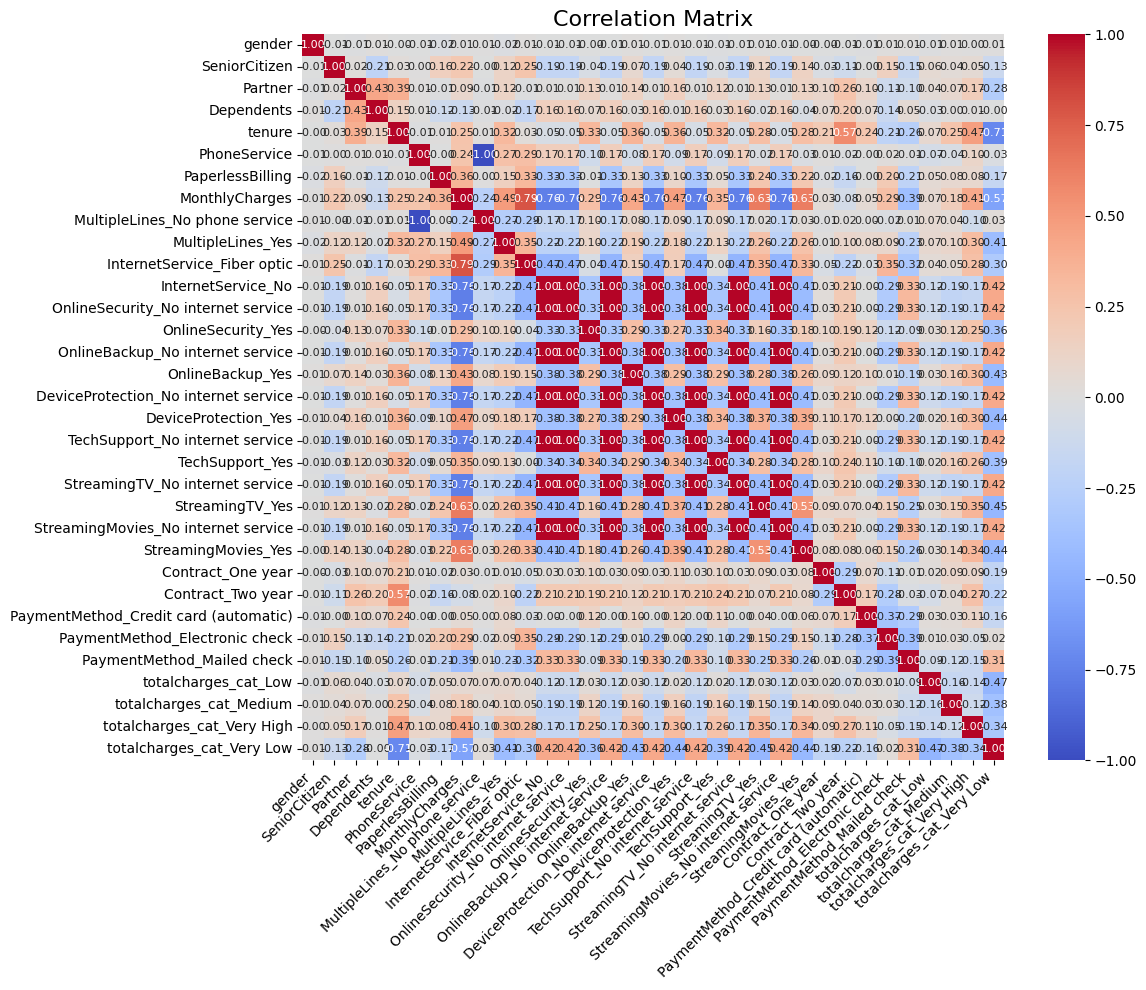

In [ ]:
# Compute the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap with improved formatting
plt.figure(figsize=(12, 10))  # Increase figure size for readability
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate x-axis labels
plt.yticks(fontsize=10)  # Adjust y-axis label size
plt.tight_layout()  # Ensure everything fits in the plot
plt.show()


In [ ]:
X = X.drop(columns=["PhoneService", "InternetService_No", "OnlineSecurity_No internet service", "OnlineBackup_No internet service",
                    "DeviceProtection_No internet service","TechSupport_No internet service", "StreamingTV_No internet service", "MonthlyCharges"])

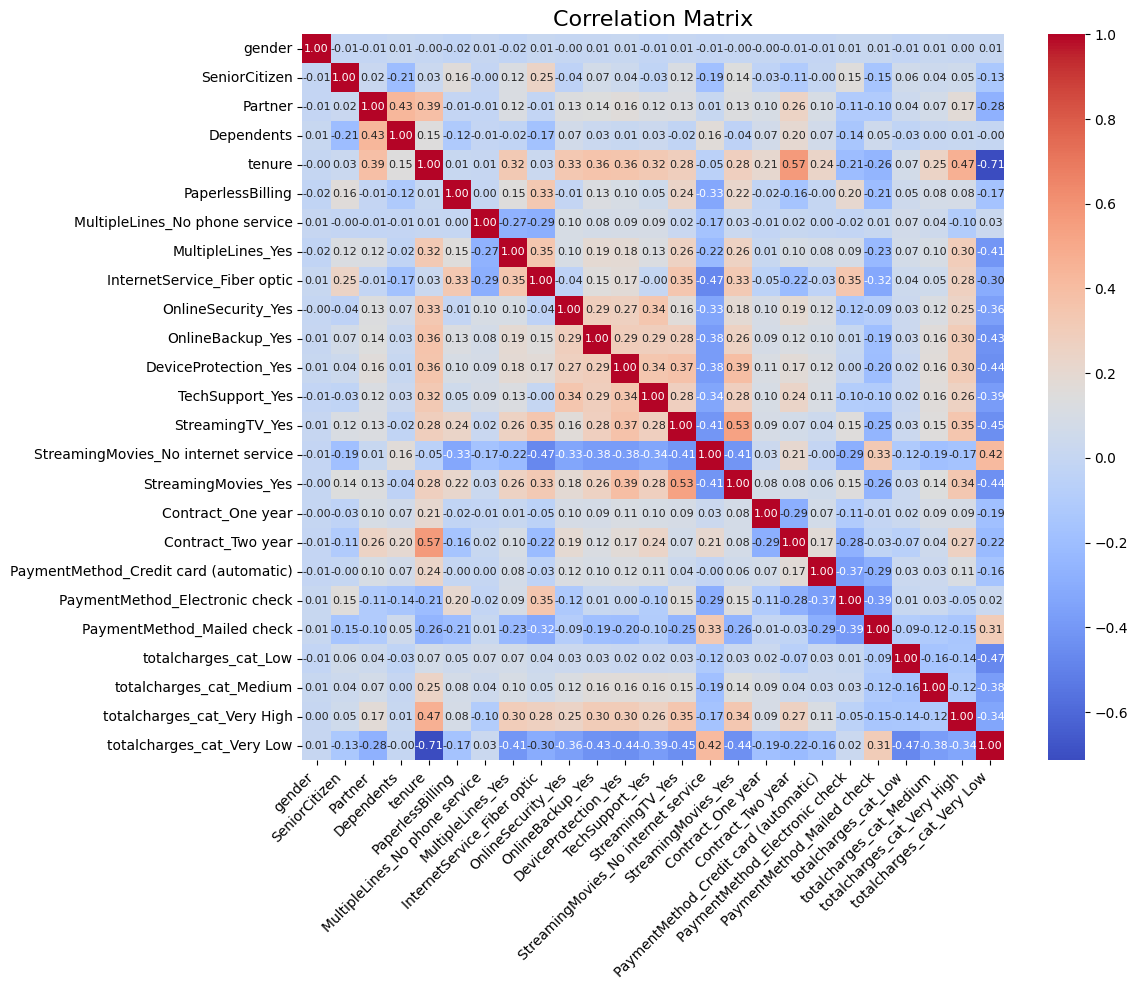

In [ ]:
# Compute the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap with improved formatting
plt.figure(figsize=(12, 10))  # Increase figure size for readability
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate x-axis labels
plt.yticks(fontsize=10)  # Adjust y-axis label size
plt.tight_layout()  # Ensure everything fits in the plot
plt.show()

## <span style="color: gold "> **2. Train test split** </span>

Train test split was adapted from our old approach as it includes stratify

In [ ]:
# Step 1: Split into 88.6% training + validation and 11.4% test (with stratification)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, Y, test_size=0.114, random_state=12, stratify=Y ##
)

# Step 2: Split the 88.6 % training + validation into 70 % training and 18.6 % validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.21, random_state=12, stratify=y_train_val
)

# Verification
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 2235 samples
Validation set: 959 samples
Test set: 411 samples


## **3. Model**

### <span style="color: gold "> 3.1. Data iterable </span>

In [ ]:
# Step 1: Define Custom Dataset
class Dataset_custom(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Step 2: Wrap Your Splits
# Step 2: Convert DataFrames to NumPy arrays and wrap in Dataset
train = Dataset_custom(X_train.values, y_train)
val = Dataset_custom(X_val.values, y_val)
test = Dataset_custom(X_test.values, y_test)


# Step 3: Create DataLoaders
batch_size = 64  # You can tune this based on your hardware
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

# Step 4: Verify
print(f"Training Loader: {len(train_loader)} batches")
print(f"Validation Loader: {len(val_loader)} batches")
print(f"Test Loader: {len(test_loader)} batches")


Training Loader: 35 batches
Validation Loader: 15 batches
Test Loader: 7 batches


### <span style="color: gold "> 3.2. Create model ANN </span>

In [ ]:
n_features=X_train.shape[1]
n_features

25

#### **Standard Training: **

In [ ]:
# # Model Artificial Neural Net
# # ================================
# class Model_NN_Clasification(nn.Module):
#     def __init__(self,input_dim,output_dim):
#         super().__init__()
#         self.input_layer    = nn.Linear(input_dim,32)
#         self.hidden_layer1  = nn.Linear(32,16)
#         self.output_layer   = nn.Linear(16,output_dim)
#         self.relu = nn.ReLU()


#     def forward(self,x):
#         out =  self.relu(self.input_layer(x))
#         out =  self.relu(self.hidden_layer1(out))
#         out =  self.output_layer(out)
#         return F.torch.log_softmax(out,dim=1)


# torch.manual_seed(828)   # BIAS
# model = Model_NN_Clasification(n_features,2)
# model

#### **improved model training: **


In [ ]:
# # Optimized Artificial Neural Network Model
# class Model_NN_Clasification(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim1=32, hidden_dim2=16, activation_fn=nn.ReLU()):
#         """
#         Args:
#             input_dim (int): Number of input features.
#             output_dim (int): Number of output classes.
#             hidden_dim1 (int): Number of neurons in the first hidden layer (default=32).
#             hidden_dim2 (int): Number of neurons in the second hidden layer (default=16).
#             activation_fn (nn.Module): Activation function to use (default=ReLU).
#         """
#         super().__init__()
#         self.input_layer = nn.Linear(input_dim, hidden_dim1)
#         self.hidden_layer1 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.output_layer = nn.Linear(hidden_dim2, output_dim)
#         self.activation = activation_fn  # Allows flexibility in trying different activation functions

#     def forward(self, x):
#         """
#         Forward pass through the network.
#         Args:
#             x (torch.Tensor): Input tensor.
#         Returns:
#             torch.Tensor: Output tensor (log probabilities for classification).
#         """
#         out = self.activation(self.input_layer(x))  # Input -> Hidden Layer 1
#         out = self.activation(self.hidden_layer1(out))  # Hidden Layer 1 -> Hidden Layer 2
#         out = self.output_layer(out)  # Hidden Layer 2 -> Output Layer
#         return F.log_softmax(out, dim=1)  # Log probabilities for classification


# # Set random seed for reproducibility
# torch.manual_seed(42)

# # Initialize the model with optimized parameters
# model = Model_NN_Clasification(
#     input_dim=n_features,    # Number of input features
#     output_dim=2,            # Number of output classes
#     hidden_dim1=32,          # Increased neurons in the first hidden layer
#     hidden_dim2=16,          # Increased neurons in the second hidden layer
#     activation_fn=nn.LeakyReLU()  # Using LeakyReLU for improved gradient flow
# )

# print(model)


#### **Model based on Binary Problem: **

In [ ]:
# Optimized Artificial Neural Network Model
class Model_NN_Clasification(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, hidden_dim4=16, activation_fn = nn.LeakyReLU(negative_slope=0.05)):
        """
        Args:
            input_dim (int): Number of input features.
            output_dim (int): Number of output classes.
            hidden_dim1 (int): Number of neurons in the first hidden layer (default=32).
            hidden_dim2 (int): Number of neurons in the second hidden layer (default=16).
            activation_fn (nn.Module): Activation function to use (default=ReLU).
        """
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim1)
        self.hidden_layer1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.hidden_layer2 = nn.Linear(hidden_dim2, hidden_dim3)
        self.hidden_layer3 = nn.Linear(hidden_dim3, hidden_dim4)
        self.output_layer = nn.Linear(hidden_dim4, output_dim)
        self.activation = activation_fn  # Allows flexibility in trying different activation functions

    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor (log probabilities for classification).
        """
        out = self.activation(self.input_layer(x))  # Input -> Hidden Layer 1
        out = self.activation(self.hidden_layer1(out))  # Hidden Layer 1 -> Hidden Layer 2
        out = self.activation(self.hidden_layer2(out))  # Hidden Layer 2 -> Hidden Layer 3
        out = self.activation(self.hidden_layer3(out))  # Hidden Layer 3 -> Hidden Layer 4
        out = self.output_layer(out)  # Hidden Layer 3 -> Output Layer
        # return F.log_softmax(out, dim=1)  # Log probabilities for classification
        return torch.sigmoid(out)


# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize the model with optimized parameters
model = Model_NN_Clasification(
    input_dim=n_features,    # Number of input features
    output_dim=1,            # Number of output classes. Binary problems must be 1
    hidden_dim1=128,          # Increased neurons in the first hidden layer
    hidden_dim2=64,            # Increased neurons in the second hidden layer
    hidden_dim3 = 32,        # Increased neurons in the third hidden layer
    hidden_dim4 = 8,
    activation_fn=nn.LeakyReLU(negative_slope=0.005)  # Using LeakyReLU for improved gradient flow
)

print(model)


Model_NN_Clasification(
  (input_layer): Linear(in_features=25, out_features=128, bias=True)
  (hidden_layer1): Linear(in_features=128, out_features=64, bias=True)
  (hidden_layer2): Linear(in_features=64, out_features=32, bias=True)
  (hidden_layer3): Linear(in_features=32, out_features=8, bias=True)
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.005)
)


In [ ]:
# Call the function using the model
count_parameters(model)

* Input Layer
Parameters:

Weights:
128 × 25 = 3200

Biases:
128

Total:
3200 + 128 = 3328

----
* Layer 1
Parameters:

Weights:
64 × 128 = 8192

Biases:
64

Total:
8192 + 64 = 8256

----
* Layer 2
Parameters:

Weights:
32 × 64 = 2048

Biases:
32

Total:
2048 + 32 = 2080

----
* Layer 3
Parameters:

Weights:
8 × 32 = 256

Biases:
8

Total:
256 + 8 = 264

----
* Layer 4
Parameters:

Weights:
1 × 8 = 8

Biases:
1

Total:
8 + 1 = 9

----
Total Parameters: 13937


## <span style="color: gold "> 4. Optimizer, Loss Function & Training Loop</span>

in the data report this section is called: Training and Validation Pipeline

In [ ]:
import time
import torch
import torch.nn as nn
import pandas as pd


criterion = nn.BCELoss()  # BCELoss to binary classification. Could be used BCE
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001) # NAdam to improve the Adam

start_time = time.time()

epochs = 45
batch_size = 64
train_losses = []
val_losses = []
train_correct = []
val_correct = []

# Convert Dataframes to NumPy arrays if necessary
X_train_np = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train_np = y_train.to_numpy() if isinstance(y_train, pd.DataFrame) else y_train
X_val_np = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
y_val_np = y_val.to_numpy() if isinstance(y_val, pd.DataFrame) else y_val

for epoch in range(epochs):
    model.train()
    trn_corr = 0
    epoch_train_loss = 0
    total_train_samples = 0

    # Training Phase
    for i in range(0, len(X_train_np), batch_size):
        # Create batch
        X_batch = torch.from_numpy(X_train_np[i:i+batch_size]).float()
        # For BCELoss, targets must be float and have the same shape as the output
        y_batch = torch.from_numpy(y_train_np[i:i+batch_size]).float()
        # If y_batch has shape (batch_size,), convert it to (batch_size, 1)
        if len(y_batch.shape) == 1:
            y_batch = y_batch.view(-1, 1)

        optimizer.zero_grad()
        y_pred = model(X_batch)  # y_pred is expected to have shape (batch_size, 1)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        batch_size_actual = X_batch.size(0)
        epoch_train_loss += loss.item() * batch_size_actual
        total_train_samples += batch_size_actual

        # To obtain the final prediction, we apply a threshold of 0.5
        predicted = (y_pred > 0.5).float()
        trn_corr += (predicted == y_batch).sum().item()

    avg_train_loss = epoch_train_loss / total_train_samples
    train_acc = trn_corr / total_train_samples * 100
    train_losses.append(avg_train_loss)
    train_correct.append(train_acc)

    # Validation Phase
    model.eval()
    val_corr = 0
    epoch_val_loss = 0
    total_val_samples = 0
    with torch.no_grad():
        for i in range(0, len(X_val_np), batch_size):
            X_val_batch = torch.from_numpy(X_val_np[i:i+batch_size]).float()
            y_val_batch = torch.from_numpy(y_val_np[i:i+batch_size]).float()
            if len(y_val_batch.shape) == 1:
                y_val_batch = y_val_batch.view(-1, 1)

            y_val_pred = model(X_val_batch)
            loss_val = criterion(y_val_pred, y_val_batch)
            batch_size_actual = X_val_batch.size(0)
            epoch_val_loss += loss_val.item() * batch_size_actual
            total_val_samples += batch_size_actual

            predicted_val = (y_val_pred > 0.5).float()
            val_corr += (predicted_val == y_val_batch).sum().item()

    avg_val_loss = epoch_val_loss / total_val_samples
    val_acc = val_corr / total_val_samples * 100
    val_losses.append(avg_val_loss)
    val_correct.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}   | Val Acc: {val_acc:.2f}%\n")

print(f"Training Duration: {time.time() - start_time:.2f} seconds")


Epoch 1/45
Train Loss: 0.6418 | Train Acc: 72.75%
Val Loss: 0.6155   | Val Acc: 72.78%

Epoch 2/45
Train Loss: 0.6027 | Train Acc: 72.84%
Val Loss: 0.5925   | Val Acc: 72.78%

Epoch 3/45
Train Loss: 0.5735 | Train Acc: 72.84%
Val Loss: 0.5588   | Val Acc: 72.78%

Epoch 4/45
Train Loss: 0.5401 | Train Acc: 72.84%
Val Loss: 0.5293   | Val Acc: 72.78%

Epoch 5/45
Train Loss: 0.5186 | Train Acc: 72.84%
Val Loss: 0.5180   | Val Acc: 72.78%

Epoch 6/45
Train Loss: 0.5119 | Train Acc: 72.84%
Val Loss: 0.5136   | Val Acc: 72.78%

Epoch 7/45
Train Loss: 0.5081 | Train Acc: 72.84%
Val Loss: 0.5098   | Val Acc: 72.78%

Epoch 8/45
Train Loss: 0.5036 | Train Acc: 72.84%
Val Loss: 0.5039   | Val Acc: 72.78%

Epoch 9/45
Train Loss: 0.4962 | Train Acc: 72.84%
Val Loss: 0.4945   | Val Acc: 72.78%

Epoch 10/45
Train Loss: 0.4869 | Train Acc: 73.78%
Val Loss: 0.4847   | Val Acc: 74.77%

Epoch 11/45
Train Loss: 0.4770 | Train Acc: 76.15%
Val Loss: 0.4729   | Val Acc: 79.25%

Epoch 12/45
Train Loss: 0.4645

#### <span style="color: gold "> 4.1. Training Plot  </span>

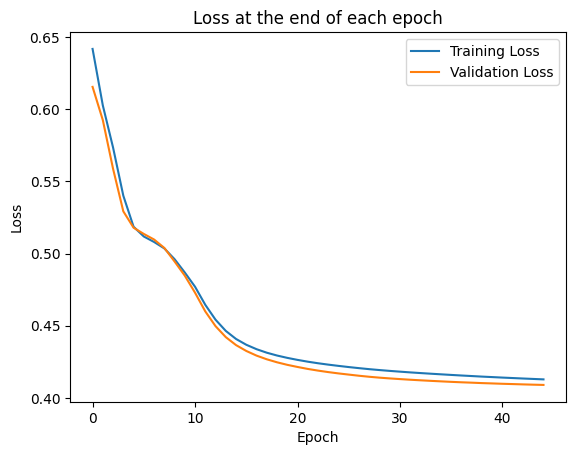

In [ ]:
#If something strange is plotted, reset the execution environment.

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### <span style="color: gold "> **5. Validation and Prediction**  </span>

##### 5.1. Validation


In [ ]:
# Convert X_train and X_val to Float tensors; y_train and y_val to Float tensors as well (for BCELoss)
X_train_torch = torch.FloatTensor(X_train.values)
X_val_torch   = torch.FloatTensor(X_val.values)
Y_train_torch = torch.FloatTensor(y_train)
Y_val_torch   = torch.FloatTensor(y_val)

# Perform predictions without computing gradients
with torch.no_grad():
    predictions_train = model(X_train_torch)  # Expected shape: [N, 1]
    predictions_val   = model(X_val_torch)

train_acc = get_accuracy_binary(predictions_train, Y_train_torch)
val_acc   = get_accuracy_binary(predictions_val, Y_val_torch)

print(f"Training Accuracy: {train_acc*100:.3f}%")
print(f"Validation Accuracy: {val_acc*100:.3f}%")


Training Accuracy: 80.000%
Validation Accuracy: 81.126%


##### <span style="color: gold "> 5.2. Prediction  </span>

In [ ]:
X_test_torch  = torch.FloatTensor(X_test.values)
Y_test_torch  = torch.FloatTensor(y_test)

# Obtain predictions without computing gradients
with torch.no_grad():
    predictions_test  = model(X_test_torch)

test_acc  = get_accuracy_binary(predictions_test, Y_test_torch)

print(f"Training Accuracy: {train_acc*100:.3f}%")
print(f"Validation Accuracy: {val_acc*100:.3f}%")
print(f"Test Accuracy: {test_acc*100:.3f}%")


Training Accuracy: 80.000%
Validation Accuracy: 81.126%
Test Accuracy: 76.886%


In [ ]:
## End

# **Track Results**

# **RUN 1 (Basic setup)**

### Experiment Results: Model Run Summary

| **Parameter**               | **Value**                                                                                 |
|-----------------------------|-------------------------------------------------------------------------------------------|
| **Model Architecture**      | Fully connected neural network (ANN)                                                     |
| **Input Layer**             | Linear(30 -> 20 neurons, ReLU activation)                                                |
| **Hidden Layer 1**          | Linear(20 -> 10 neurons, ReLU activation)                                                |
| **Output Layer**            | Linear(10 -> 2 neurons, LogSoftmax for classification)                                    |
| **Total Parameters**        | 852                                                                                      |
| **Optimizer**               | Adam (Learning Rate = 0.01)                                                              |
| **Loss Function**           | CrossEntropyLoss                                                                         |
| **Batch Size**              | 100                                                                                      |
| **Number of Epochs**        | 10                                                                                       |
| **Data Splits**             | - Training: 60% (2163 samples)                                                           |
|                             | - Validation: 20% (721 samples)                                                          |
|                             | - Test: 20% (721 samples)                                                                |
| **Training Duration**       | 0.54 seconds                       |
| **Results**                 |                                                                                           |
| - **Training Accuracy**     | 82.43%                                                                                   |
| - **Validation Accuracy**   | 80.03%                                                                                   |
| - **Test Accuracy**         | 76.56%                                                                                   |
| **Train Loss**              | Final epoch: 0.2841                                                                      |
| **Validation Loss**         | Final epoch: 0.5396                                                                      |
| **Test Predictions Summary**|                                                                                           |
| - **Correct Predictions**   | 552                                                                                      |
| - **Incorrect Predictions** | 169                                                                                      |
| - **Test Accuracy**         | 76.56%                                                                                   |

### Additional Notes:
- Overfitting is evident in the divergence of training and validation losses after several epochs.
- Maybe try: Early stopping, dropout regularization, or weight decay could be introduced in future runs to improve generalization.


*This was the Train and Validation Loss*

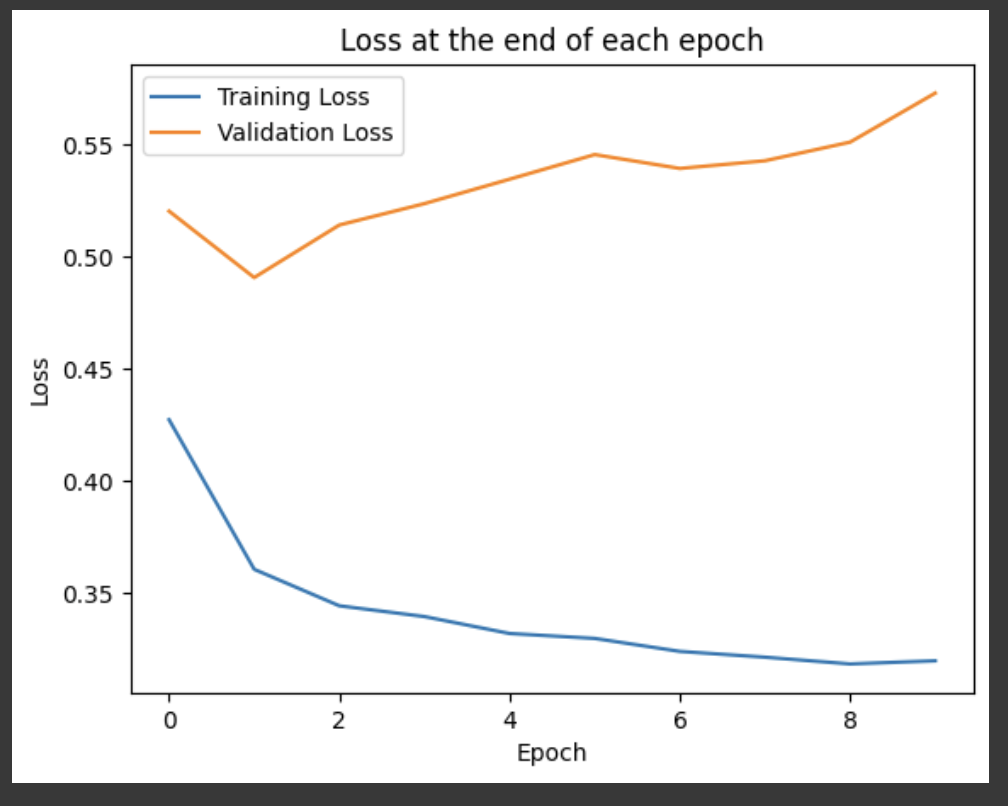

# **After the first set of improvements (Multiclass Problem):**

### Experiment Results: Model Run Summary (Updated)

| **Parameter**               | **Value**                                                                                 |
|-----------------------------|-------------------------------------------------------------------------------------------|
| **Model Architecture**      | Fully connected neural network (ANN)                                                     |
| **Input Layer**             | Linear(30 -> 32 neurons, LeakyReLU activation)                                           |
| **Hidden Layer 1**          | Linear(32 -> 16 neurons, LeakyReLU activation)                                           |
| **Output Layer**            | Linear(16 -> 2 neurons, LogSoftmax for classification)                                    |
| **Total Parameters**        | 1,554                                                                                    |
| **Optimizer**               | Adam (Learning Rate = 0.001)                                                             |
| **Loss Function**           | CrossEntropyLoss                                                                         |
| **Batch Size**              | 64                                                                                       |
| **Number of Epochs**        | 20                                                                                       |
| **Data Splits**             | - Training: 60% (2163 samples)                                                           |
|                             | - Validation: 20% (721 samples)                                                          |
|                             | - Test: 20% (721 samples)                                                                |
| **Training Duration**       | 1.15 seconds                                                                             |
| **Results**                 |                                                                                           |
| - **Training Accuracy**     | 82.48%                                                                                   |
| - **Validation Accuracy**   | 80.58%                                                                                   |
| - **Test Accuracy**         | 77.81%                                                                                   |
| **Train Loss**              | Final epoch: 0.4123                                                                      |
| **Validation Loss**         | Final epoch: 0.4394                                                                      |
| **Test Predictions Summary**|                                                                                           |
| - **Correct Predictions**   | 561                                                                                      |
| - **Incorrect Predictions** | 160                                                                                      |
| - **Test Accuracy**         | 77.81%                                                                                   |

### Additional Notes:
- **Learning Rate Adjustment:** Reduced from 0.01 to 0.001, which improved stability in training and validation losses.
- **Validation Loss Plateau:** Validation loss stabilized around epoch 12, suggesting early stopping could reduce training time.
- **Improved Model Generalization:** Test accuracy is consistent with validation accuracy, indicating better generalization compared to earlier runs.
- **Next Steps:** Introduce regularization (e.g., weight decay or dropout) to further improve performance and reduce the validation loss.


*This was the Train and Validation Loss*

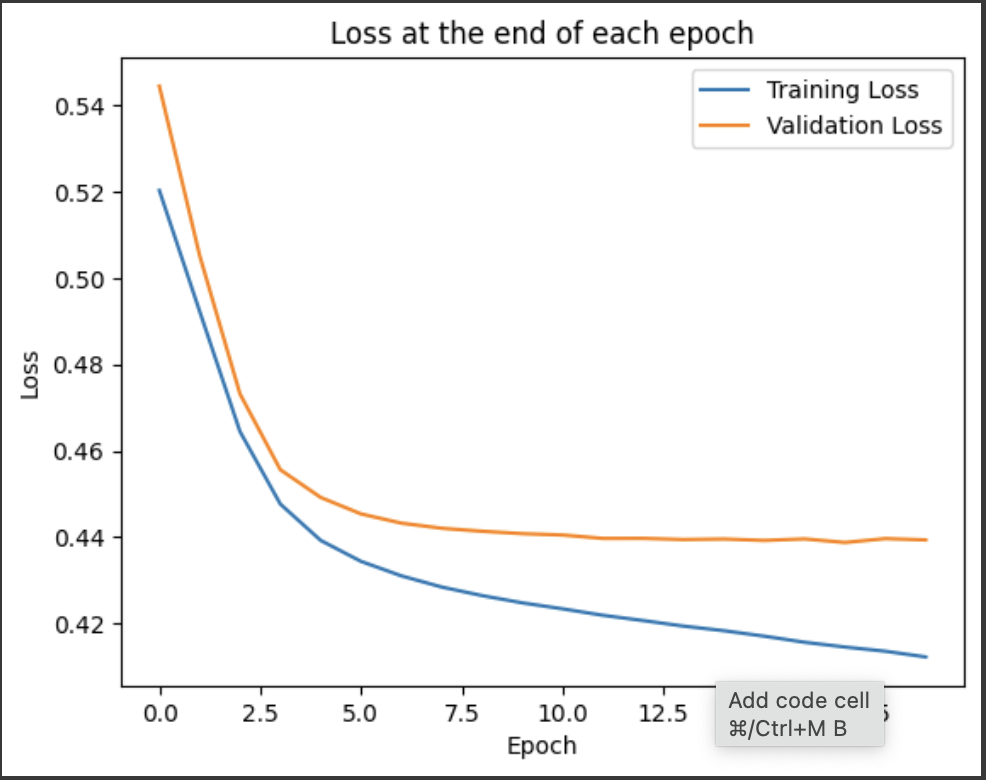

# **After the second set of improvements (Binary Problem):**

Changes Performed:
-	Addition of TotalCharges transformation to categorical
-	Proportion of Train_Test_split. From 60/20/20 to 70/17.6/11.4
Because this paper: https://onlinelibrary.wiley.com/doi/full/10.1002/sam.11583
-	Addition 1 more hidden layer
-	Model output as a sigmoid function. Also output_dim = 1 (instead of 2)
-	Display of count_parameters
-	Criterion from CrossEntropyLoss to BCELoss
-	Because our output is binary (1 or 0, yes or no)
-	Training Loop to adapt it to nn.BCELoss()
-	Validation and testing measuring adapted to Binary Output

### Experiment Results: Model Run Summary

| **Parameter**               | **Value**                                                                                 |
|-----------------------------|-------------------------------------------------------------------------------------------|
| **Model Architecture**      | Fully connected neural network (ANN)                                                     |
| **Input Layer**             | Linear(25 -> 128 neurons, LeakyReLU activation)                                                |
| **Hidden Layer 1**          | Linear(128 -> 64 neurons, LeakyReLU activation)     
|**HiddenLayer 2**            | Linear(64 -> 32 neurons, LeakyReLU activation)
|**HiddenLayer 3**            | Linear(32 -> 16 neurons, LeakyReLU activation)
| **Output Layer**            | Linear(16 -> 1 neurons, sigmoid function for classification)                                    |
| **Total Parameters**        | 13,937                                                                                      |
| **Optimizer**               | NAdam (Learning Rate = 0.001)                                                              |
| **Loss Function**           | BCELoss                                                                         |
| **Batch Size**              | 64                                                                                      |
| **Number of Epochs**        | 45                                                                                       |
| **Data Splits**             | - Training: 70% (2235 samples)                                                           |
|                             | - Validation: 20% (959 samples)                                                          |
|                             | - Test: 20% (411 samples)                                                                |
| **Training Duration**       | 2.45 seconds                       |
| **Results**                 |                                                                                           |
| - **Training Accuracy**     | 80.000%                                                                                   |
| - **Validation Accuracy**   | 81.126%                                                                                   |
| - **Test Accuracy**         | 76.886%                                                                                   |
| **Train Loss**              | Final epoch: 0.4131                                                                      |
| **Validation Loss**         | Final epoch: 0.4128                                                                      |
                                                                         |

###Additional Notes:

- Althought it does not appear in this table, a neural network equal as the second approach (multilabel) was performed, obtaining even worse results.


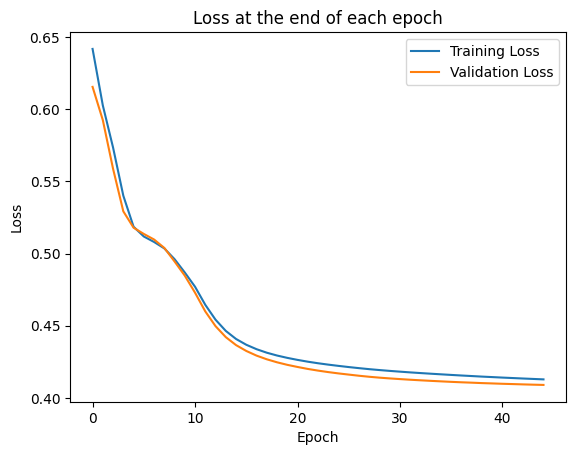